## Useful ffmpeg resources
https://trac.ffmpeg.org/wiki/How%20to%20speed%20up%20/%20slow%20down%20a%20video

In [2]:
import sys

import argparse
import logging
from os.path import join
logger = logging.getLogger(__name__)
import numpy as np
import scipy.io as sio
import matplotlib as mpl
import scipy.linalg as LA
import matplotlib.pyplot as plt
sys.path.append("../scripts")

from gmm.gmm import GMM
from gmm.gaussian_reg import regress_gauss_mix
from cost import Cost
from config import Vxf0, options, ds_options
from stabilizer.traj_stab import stabilizer
from utils.utils import guess_init_lyap, realmin
from utils.dataloader import load_saved_mat_file
from utils.gen_utils import *
from utils.dataloader import load_saved_mat_file
from visualization.visualizer import Visualizer
from stabilizer.correct_trajos import CorrectTrajectories, check_options


In [3]:
args = Bundle(dict(pause_time=.3, traj_nums=20e3, model='s', rho0=1.0, kappa0=.1, off_priors=True))
models = {'w': 'w.mat', 's': 'Sshape.mat'}
data, demoIdx, Priors_EM, Mu_EM, Sigma_EM = load_saved_mat_file(join('../scripts/data', models[args.model]))

Vxf0['L'] = 1 #if args.model == 's' else 2
Vxf0['d'] = data.shape[0]//2
Vxf0.update(Vxf0)

Vxf0 = guess_init_lyap(data, Vxf0, options['int_lyap_random'])
cost = Cost(nDemo = 1, success=True, Nfeval = 0, verbose=False)

In [4]:
"Learn Lyapunov Function Strictly from Data"
while cost.success:
    info('Optimizing the lyapunov function')
    Vxf, J = cost.optimize_lyapunov(Vxf0, data, options)
    old_l = Vxf0['L']
    Vxf0['L'] += 1
    print('Constraints violated. increasing the size of L from {} --> {}'.format(old_l, Vxf0['L']))
    if cost.success:
        print('optimization succeeded without violating constraints')
        break

/home/lex/miniconda3/envs/37/lib/python3.7/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +
/home/lex/miniconda3/envs/37/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:186: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Constraints violated. increasing the size of L from 1 --> 2
optimization succeeded without violating constraints


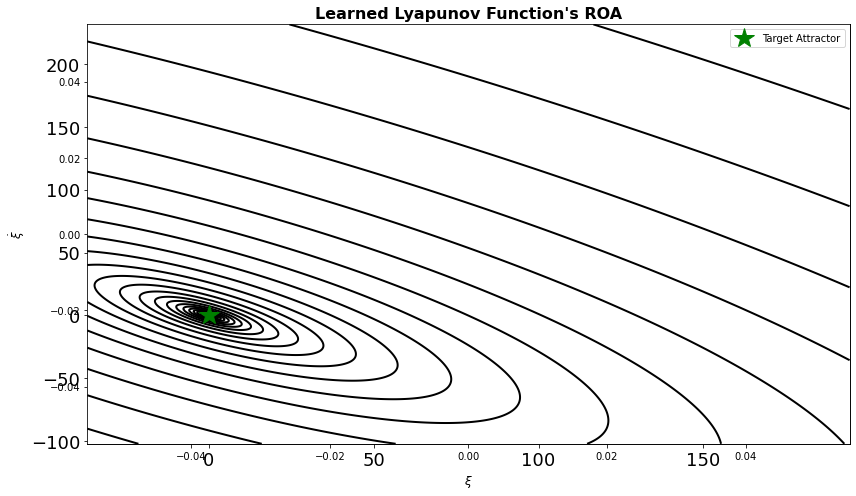

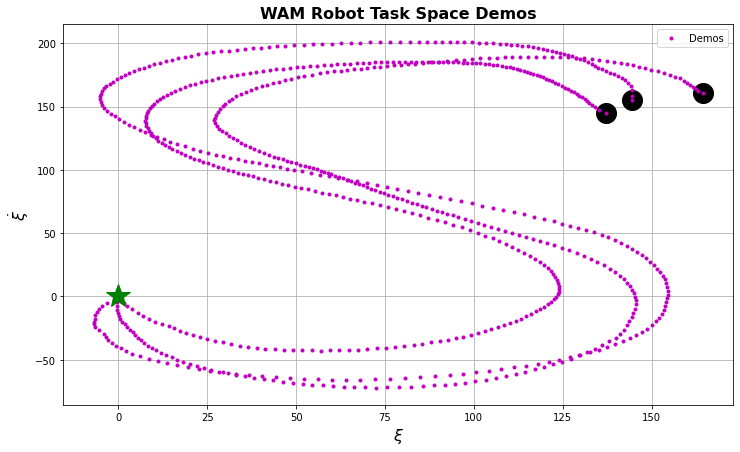

In [6]:
fontdict = {'fontsize':16, 'fontweight':'bold'}
# https://matplotlib.org/stable/users/interactive.html
plt.ion()

savedict = dict(save=True, savename='demos_w.jpg',\
        savepath=join("..", "scripts/docs"))
viz = Visualizer(winsize=(12, 7), savedict=savedict, data=data,
                labels=['Trajs', 'Dt(Trajs)']*2, alphas = [.15]*4,
                fontdict=fontdict)

Xinit = data[:Vxf['d'], demoIdx[0, :-1]]
level_args = dict(disp=True, levels = [], save=True)
viz.savedict["savename"]=f"demos_{args.model}.jpg"
viz.init_demos(Xinit, save=True)
# Optimize and plot the level sets of the Lyapunov function
viz.savedict["savename"]=f"level_sets_{args.model}.jpg"
handles = viz.level_sets(Vxf, cost, **level_args)
viz.draw()

In [9]:
if args.off_priors:
    mu, sigma, priors = Mu_EM, Sigma_EM, Priors_EM
else:
    gmm = GMM(num_clusters=options['num_clusters'])
    gmm.update(data.T, K=options['num_clusters'], max_iterations=100)
    mu, sigma, priors = gmm.mu.T, gmm.sigma.T, gmm.logmass.T

"Now stabilize the learned dynamics"
traj = list(range(Vxf['d']))
traj_derivs = np.arange(Vxf['d'], 2 * Vxf['d'])
# print(f'demoIdx: {demoIdx}')
Xinit = data[:Vxf['d'], demoIdx[0, :-1]]
stab_args = {'time_varying': False, 'cost': cost}
gmr_handle = lambda x: regress_gauss_mix(priors, mu, sigma, x, traj, traj_derivs)
stab_handle = lambda x: stabilizer(x, gmr_handle, Vxf, args.rho0, args.kappa0, **stab_args) #, priors, mu, sigma

if args.traj_nums:
    ds_options['traj_nums'] = args.traj_nums
ds_options['pause_time'] = args.pause_time
traj_corr = CorrectTrajectories(Xinit, [], stab_handle, Bundle(ds_options))


In [10]:
x_hist = np.stack(traj_corr.x_hist)
xd_hist = np.stack(traj_corr.xd_hist)
t_hist = np.stack(traj_corr.t_hist)
xT = traj_corr.XT

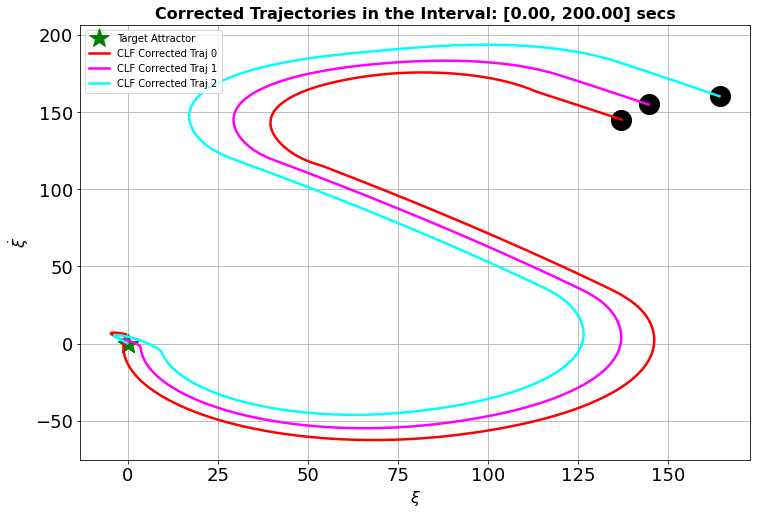

In [13]:
f = plt.figure(figsize=(12, 8))
plt.clf()
f.tight_layout()
args.fontdict = {'fontsize':16, 'fontweight':'bold'}

_labelsize = 18
nbSPoint = x_hist.shape[-1]
cm = plt.get_cmap('ocean')
ax = f.gca()
ax.grid('on')
colors =['r', 'magenta', 'cyan']

# plot the target attractors
ax.plot(xT[0], xT[1], 'g*',markersize=20,linewidth=1.5, label='Target Attractor')

for j in range(nbSPoint):
    color = cm(1.0 * j / nbSPoint)
    ax.plot(Xinit[0, j], Xinit[1, j], 'ko', markersize=20,  linewidth=2.5)
    ax.plot(x_hist[:, 0, j], x_hist[:, 1, j], color=colors[j], markersize=2,  linewidth=2.5, label=f'CLF Corrected Traj {j}')

ax.set_xlabel('$\\xi$', fontdict=args.fontdict)
ax.set_ylabel('$\\dot{\\xi}$', fontdict=args.fontdict)

ax.xaxis.set_tick_params(labelsize=_labelsize)
ax.yaxis.set_tick_params(labelsize=_labelsize)

ax.legend(loc='upper left') #, bbox_to_anchor=(-1, .5))
ax.set_title(f'Corrected Trajectories in the Interval: [{t_hist[0]:.2f}, {t_hist[-1]:.2f}] secs', fontdict=args.fontdict)

plt.savefig(join("../scripts", "docs", f'corrected_traj_{args.model}.jpg'))
plt.show()

In [40]:
Vx = np.arange(1, 7, dtype=np.float64).reshape(2, 3)
u = np.zeros_like(Vx)
ind = (tuple(range(Vx.shape[0])), np.array([0, 1, 1], dtype=np.intp), )
print(ind); print(); print(Vx)
u[np.ix_(*ind)] = Vx[np.ix_(*ind)]

((0, 1), array([0, 1, 1]))

[[1. 2. 3.]
 [4. 5. 6.]]


In [5]:
help(plt.close)

Help on function close in module matplotlib.pyplot:

close(fig=None)
    Close a figure window.
    
    Parameters
    ----------
    fig : None or int or str or `.Figure`
        The figure to close. There are a number of ways to specify this:
    
        - *None*: the current figure
        - `.Figure`: the given `.Figure` instance
        - ``int``: a figure number
        - ``str``: a figure name
        - 'all': all figures



In [7]:
from scipy.optimize import minimize, NonlinearConstraint, BFGS

help(NonlinearConstraint)

Help on class NonlinearConstraint in module scipy.optimize._constraints:

class NonlinearConstraint(builtins.object)
 |  NonlinearConstraint(fun, lb, ub, jac='2-point', hess=<scipy.optimize._hessian_update_strategy.BFGS object at 0x7fc5df2f5d50>, keep_feasible=False, finite_diff_rel_step=None, finite_diff_jac_sparsity=None)
 |  
 |  Nonlinear constraint on the variables.
 |  
 |  The constraint has the general inequality form::
 |  
 |      lb <= fun(x) <= ub
 |  
 |  Here the vector of independent variables x is passed as ndarray of shape
 |  (n,) and ``fun`` returns a vector with m components.
 |  
 |  It is possible to use equal bounds to represent an equality constraint or
 |  infinite bounds to represent a one-sided constraint.
 |  
 |  Parameters
 |  ----------
 |  fun : callable
 |      The function defining the constraint.
 |      The signature is ``fun(x) -> array_like, shape (m,)``.
 |  lb, ub : array_like
 |      Lower and upper bounds on the constraint. Each array must have